# Research Question 1: When Does Ad Fatigue Set In?

**Question:** How many impressions does it take before an ad's CTR meaningfully declines?

---

## Prerequisites

**Input Data**: `../data/processed/data_with_all_features.csv.gz` (created by `03_feature_engineering.ipynb`)

**Output Data**: 
- `../results/figures/rq1_*.png` (visualizations)
- `../results/tables/rq1_*.csv` (statistical results)

## Data Pipeline Position

```
01_data_acquisition → 02_exploratory_analysis → 03_feature_engineering → [04_rq1_ctr_fatigue_analysis.ipynb]
```

## Source Module Dependencies

This notebook primarily uses **custom analysis functions defined inline** rather than src modules. This allows for transparent, reproducible analysis where all logic is visible in the notebook.

**Key functions defined in this notebook:**
- `compute_cohort_ctr_by_exposure()`: Computes CTR at each exposure level for a fixed cohort
- `test_ctr_difference()`: Statistical test for CTR decline between exposure levels
- `fit_decay_curve()`: Fits exponential/power-law decay models

---

## The Survivorship Bias Problem

**Why does CTR appear to INCREASE with exposure in naive analysis?**

When we simply group by exposure count and compute mean CTR, we're comparing different populations:
- At exposure 1: ALL users (everyone starts with a first impression)
- At exposure 10: ONLY users who stayed long enough to see 10 impressions

Users who see many ads are **inherently more engaged** (that's why they keep seeing ads!), so their CTR is higher.

## Our Approach: Time-Bounded Within-User Analysis

To correctly measure fatigue, we:

1. **Use sequential exposure_count** - the Nth impression for each user-campaign pair (computed chronologically)
2. **Compare within users** - same users at exposure 1 vs exposure N (controls for user-level confounders)
3. **Cohort analysis** - follow users who reached at least N exposures to avoid survivorship bias
4. **Time-bounded metrics** - compute CTR at each exposure level as a snapshot, not cumulative


In [19]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Load data
df = pd.read_csv('../data/processed/data_with_all_features.csv.gz')
print(f"Loaded {len(df):,} impression records")
print(f"Unique users: {df['uid'].nunique():,}")
print(f"Unique campaigns: {df['campaign'].nunique():,}")


Loaded 500,000 impression records
Unique users: 297,407
Unique campaigns: 675


## Step 1: Understanding the Exposure Count Column

The `exposure_count` column represents the **Nth impression** for each user-campaign pair, computed chronologically.
- exposure_count = 1 → This is the first time this user has seen this campaign
- exposure_count = 5 → This is the 5th time this user has seen this campaign

This is the correct metric for fatigue analysis (not `exposure_count_168h` which is time-windowed and biased toward high-frequency users).


In [21]:
# Verify exposure_count is correct (Nth sequential impression)
print("=" * 70)
print("EXPOSURE COUNT DISTRIBUTION")
print("=" * 70)
print(f"\nExposure count statistics:")
print(df['exposure_count'].describe())

# Distribution of max exposures per user-campaign pair
user_campaign_max_exp = df.groupby(['uid', 'campaign'])['exposure_count'].max()
print(f"\nMax exposure per user-campaign pair:")
print(user_campaign_max_exp.describe())

# Percentage of impressions at each exposure level
exp_dist = df['exposure_count'].value_counts().sort_index().head(20)
exp_pct = (exp_dist / len(df) * 100).round(2)
print(f"\n% of impressions at each exposure level:")
for exp, pct in exp_pct.items():
    print(f"  Exposure {exp}: {pct}%")


EXPOSURE COUNT DISTRIBUTION

Exposure count statistics:
count    500000.000000
mean          2.762458
std           5.942473
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         196.000000
Name: exposure_count, dtype: float64

Max exposure per user-campaign pair:
count    323705.000000
mean          1.544616
std           2.145561
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         196.000000
Name: exposure_count, dtype: float64

% of impressions at each exposure level:
  Exposure 1: 64.74%
  Exposure 2: 11.73%
  Exposure 3: 6.34%
  Exposure 4: 3.99%
  Exposure 5: 2.73%
  Exposure 6: 1.97%
  Exposure 7: 1.47%
  Exposure 8: 1.14%
  Exposure 9: 0.91%
  Exposure 10: 0.72%
  Exposure 11: 0.59%
  Exposure 12: 0.49%
  Exposure 13: 0.4%
  Exposure 14: 0.34%
  Exposure 15: 0.28%
  Exposure 16: 0.24%
  Exposure 17: 0.2%
  Exposure 18: 0.18%
  Exposure 19: 0.15%
  Exposure 20: 0.13%


## Step 2: Diagnose Survivorship Bias

First, let's demonstrate why naive CTR-by-exposure analysis is misleading.


In [23]:
print("=" * 70)
print("SURVIVORSHIP BIAS DIAGNOSIS")
print("=" * 70)

# Naive analysis: CTR by exposure count (THIS IS BIASED)
naive_ctr = df.groupby('exposure_count')['click'].agg(['mean', 'count']).reset_index()
naive_ctr.columns = ['exposure_count', 'ctr', 'n_impressions']
naive_ctr = naive_ctr[naive_ctr['n_impressions'] >= 100]  # Min samples

print("\nNAIVE CTR BY EXPOSURE (BIASED - DO NOT USE):")
print(f"{'Exp':<6} {'CTR':<10} {'N Impressions':<15}")
print("-" * 35)
for _, row in naive_ctr.head(15).iterrows():
    print(f"{int(row['exposure_count']):<6} {row['ctr']:.4f}     {int(row['n_impressions']):,}")

# Check trend
first_ctr = naive_ctr[naive_ctr['exposure_count'] == 1]['ctr'].values[0]
exp_5_ctr = naive_ctr[naive_ctr['exposure_count'] == 5]['ctr'].values[0]
exp_10_ctr = naive_ctr[naive_ctr['exposure_count'] == 10]['ctr'].values[0] if 10 in naive_ctr['exposure_count'].values else None

print(f"\n  MISLEADING TREND (due to survivorship bias):")
print(f"   CTR at exposure 1: {first_ctr:.4f}")
print(f"   CTR at exposure 5: {exp_5_ctr:.4f} ({(exp_5_ctr/first_ctr - 1)*100:+.1f}% vs exp 1)")
if exp_10_ctr:
    print(f"   CTR at exposure 10: {exp_10_ctr:.4f} ({(exp_10_ctr/first_ctr - 1)*100:+.1f}% vs exp 1)")
print(f"\n   This makes it look like CTR INCREASES with exposure - clearly wrong!")


SURVIVORSHIP BIAS DIAGNOSIS

NAIVE CTR BY EXPOSURE (BIASED - DO NOT USE):
Exp    CTR        N Impressions  
-----------------------------------
1      0.3043     323,705
2      0.3405     58,648
3      0.3539     31,720
4      0.3647     19,929
5      0.3850     13,664
6      0.3954     9,845
7      0.4058     7,353
8      0.4214     5,717
9      0.4280     4,535
10     0.4333     3,607
11     0.4604     2,952
12     0.4665     2,431
13     0.4760     1,983
14     0.4884     1,675
15     0.5154     1,393

  MISLEADING TREND (due to survivorship bias):
   CTR at exposure 1: 0.3043
   CTR at exposure 5: 0.3850 (+26.5% vs exp 1)
   CTR at exposure 10: 0.4333 (+42.4% vs exp 1)

   This makes it look like CTR INCREASES with exposure - clearly wrong!


In [25]:
# Demonstrate the bias: Compare first-exposure CTR for different user types
print("\n" + "=" * 70)
print("WHY THE BIAS OCCURS")
print("=" * 70)

# Get max exposure per user-campaign pair
user_campaign_info = df.groupby(['uid', 'campaign']).agg({
    'exposure_count': 'max',
    'click': 'sum'
}).reset_index()
user_campaign_info.columns = ['uid', 'campaign', 'max_exposure', 'total_clicks']

# Get first exposure records
first_exposure_df = df[df['exposure_count'] == 1].merge(
    user_campaign_info[['uid', 'campaign', 'max_exposure']],
    on=['uid', 'campaign']
)

# Compare first-exposure CTR by eventual max exposure
print("\nFirst-exposure CTR by user's eventual total exposure:")
print("(If no bias, these should be similar)")
print(f"\n{'User Type':<30} {'First Exp CTR':<15} {'N Users':<15}")
print("-" * 60)

exposure_groups = [
    (1, 1, "1 impression only"),
    (2, 3, "2-3 impressions"),
    (4, 10, "4-10 impressions"),
    (11, 50, "11-50 impressions"),
    (51, 1000, "50+ impressions")
]

first_exp_ctrs = []
for min_exp, max_exp, label in exposure_groups:
    mask = (first_exposure_df['max_exposure'] >= min_exp) & (first_exposure_df['max_exposure'] <= max_exp)
    group = first_exposure_df[mask]
    if len(group) >= 50:
        ctr = group['click'].mean()
        first_exp_ctrs.append((label, ctr, len(group)))
        print(f"{label:<30} {ctr:.4f}          {len(group):,}")

print(f"\nINSIGHT:")
if len(first_exp_ctrs) >= 2:
    low_exp_ctr = first_exp_ctrs[0][1]
    high_exp_ctr = first_exp_ctrs[-1][1]
    if high_exp_ctr > low_exp_ctr:
        print(f"   Users who will see 50+ impressions have {high_exp_ctr/low_exp_ctr:.2f}x higher CTR")
        print(f"   at their FIRST exposure ({high_exp_ctr:.4f} vs {low_exp_ctr:.4f}).")
        print(f"   This confirms SELECTION BIAS: high-exposure users are inherently more engaged.")



WHY THE BIAS OCCURS

First-exposure CTR by user's eventual total exposure:
(If no bias, these should be similar)

User Type                      First Exp CTR   N Users        
------------------------------------------------------------
1 impression only              0.2732          265,057
2-3 impressions                0.4061          38,719
4-10 impressions               0.5125          16,977
11-50 impressions              0.5598          2,912

INSIGHT:
   Users who will see 50+ impressions have 2.05x higher CTR
   at their FIRST exposure (0.5598 vs 0.2732).
   This confirms SELECTION BIAS: high-exposure users are inherently more engaged.


## Step 3: Correct Analysis - Within-User CTR Change

To correctly measure fatigue, we compare the **same users** at different exposure levels.

For each user-campaign pair with multiple exposures:
- CTR at exposure 1 = click rate at their first impression
- CTR at exposure N = click rate at their Nth impression

This controls for user-level confounders because we're comparing the same users to themselves.


In [26]:
print("=" * 70)
print("CORRECT ANALYSIS: WITHIN-USER CTR BY EXPOSURE")
print("=" * 70)

def compute_cohort_ctr_by_exposure(
    df: pd.DataFrame,
    min_exposures: int = 5,
    max_exposure_to_analyze: int = 20
) -> Tuple[pd.DataFrame, int]:
    """
    Compute CTR at each exposure level using cohort analysis.
    
    Only includes user-campaign pairs that reached at least min_exposures,
    ensuring we compare the same cohort across exposure levels.
    
    This is a time-bounded analysis: CTR at exposure N is the click rate
    of the Nth impression for each user-campaign pair.
    """
    # Get user-campaign pairs with sufficient exposures
    user_campaign_max = df.groupby(['uid', 'campaign'])['exposure_count'].max()
    cohort_pairs = user_campaign_max[user_campaign_max >= min_exposures].reset_index()
    cohort_pairs = cohort_pairs[['uid', 'campaign']]
    
    # Filter to cohort
    cohort_df = df.merge(cohort_pairs, on=['uid', 'campaign'], how='inner')
    
    # Compute CTR at each exposure level (time-bounded: CTR of Nth impression)
    results = []
    for exp in range(1, max_exposure_to_analyze + 1):
        exp_data = cohort_df[cohort_df['exposure_count'] == exp]
        if len(exp_data) >= 50:
            ctr = exp_data['click'].mean()
            n = len(exp_data)
            # Confidence interval
            se = np.sqrt(ctr * (1 - ctr) / n)
            ci_lower = max(0, ctr - 1.96 * se)
            ci_upper = min(1, ctr + 1.96 * se)
            results.append({
                'exposure': exp,
                'ctr': ctr,
                'n_impressions': n,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper
            })
    
    return pd.DataFrame(results), len(cohort_pairs)

# Analyze cohort with at least 5 exposures
cohort_ctr, cohort_size = compute_cohort_ctr_by_exposure(df, min_exposures=5, max_exposure_to_analyze=20)

print(f"\nCohort Analysis: Users with at least 5 exposures")
print(f"Cohort size: {cohort_size:,} user-campaign pairs")
print(f"\n{'Exposure':<10} {'CTR':<10} {'95% CI':<22} {'N Impressions':<15}")
print("-" * 60)
for _, row in cohort_ctr.iterrows():
    ci = f"[{row['ci_lower']:.4f}, {row['ci_upper']:.4f}]"
    print(f"{int(row['exposure']):<10} {row['ctr']:.4f}     {ci:<22} {int(row['n_impressions']):,}")


CORRECT ANALYSIS: WITHIN-USER CTR BY EXPOSURE

Cohort Analysis: Users with at least 5 exposures
Cohort size: 13,664 user-campaign pairs

Exposure   CTR        95% CI                 N Impressions  
------------------------------------------------------------
1          0.5285     [0.5201, 0.5368]       13,664
2          0.4475     [0.4391, 0.4558]       13,664
3          0.4158     [0.4075, 0.4240]       13,664
4          0.3918     [0.3836, 0.4000]       13,664
5          0.3850     [0.3769, 0.3932]       13,664
6          0.3954     [0.3858, 0.4051]       9,845
7          0.4058     [0.3946, 0.4170]       7,353
8          0.4214     [0.4086, 0.4342]       5,717
9          0.4280     [0.4136, 0.4424]       4,535
10         0.4333     [0.4172, 0.4495]       3,607
11         0.4604     [0.4424, 0.4783]       2,952
12         0.4665     [0.4466, 0.4863]       2,431
13         0.4760     [0.4541, 0.4980]       1,983
14         0.4884     [0.4644, 0.5123]       1,675
15         0.5154     

In [27]:
# Calculate decline from exposure 1
if len(cohort_ctr) >= 3:
    baseline_ctr = cohort_ctr[cohort_ctr['exposure'] == 1]['ctr'].values[0]
    
    print("\n" + "=" * 70)
    print("CTR DECLINE FROM BASELINE (Exposure 1)")
    print("=" * 70)
    print(f"\nBaseline CTR (Exposure 1): {baseline_ctr:.4f}")
    print(f"\n{'Exposure':<10} {'CTR':<10} {'Absolute Change':<18} {'Relative Change':<18}")
    print("-" * 60)
    
    for _, row in cohort_ctr.iterrows():
        exp = int(row['exposure'])
        ctr = row['ctr']
        abs_change = ctr - baseline_ctr
        rel_change = (ctr - baseline_ctr) / baseline_ctr * 100 if baseline_ctr > 0 else 0
        print(f"{exp:<10} {ctr:.4f}     {abs_change:+.4f}           {rel_change:+.1f}%")



CTR DECLINE FROM BASELINE (Exposure 1)

Baseline CTR (Exposure 1): 0.5285

Exposure   CTR        Absolute Change    Relative Change   
------------------------------------------------------------
1          0.5285     +0.0000           +0.0%
2          0.4475     -0.0810           -15.3%
3          0.4158     -0.1127           -21.3%
4          0.3918     -0.1366           -25.9%
5          0.3850     -0.1434           -27.1%
6          0.3954     -0.1330           -25.2%
7          0.4058     -0.1226           -23.2%
8          0.4214     -0.1071           -20.3%
9          0.4280     -0.1005           -19.0%
10         0.4333     -0.0951           -18.0%
11         0.4604     -0.0681           -12.9%
12         0.4665     -0.0620           -11.7%
13         0.4760     -0.0524           -9.9%
14         0.4884     -0.0401           -7.6%
15         0.5154     -0.0130           -2.5%
16         0.4932     -0.0352           -6.7%
17         0.5106     -0.0179           -3.4%
18        

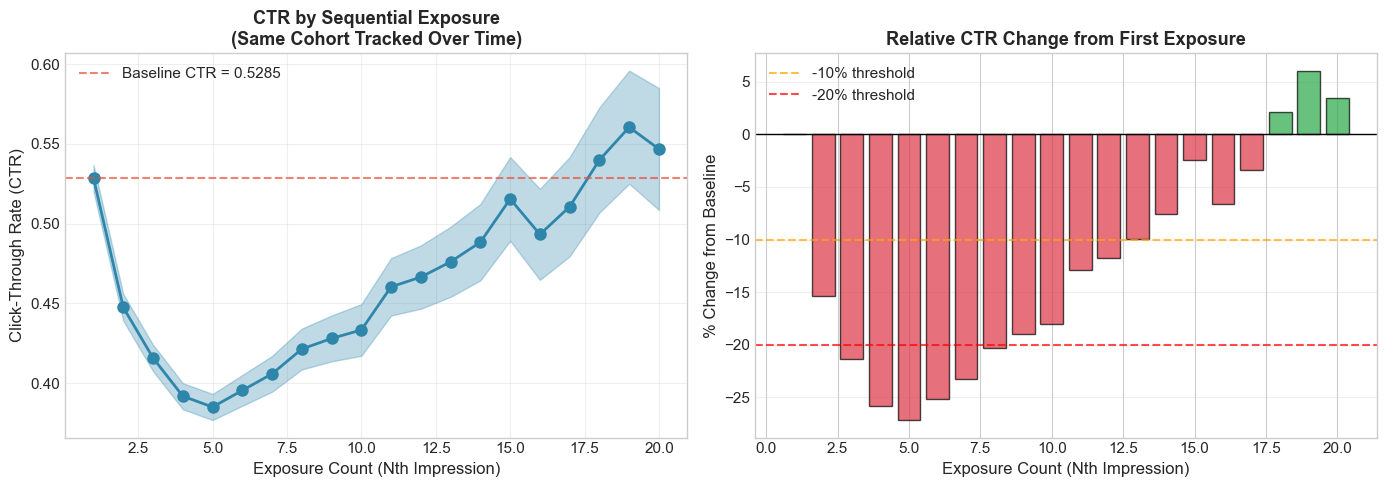


Figure saved to ../results/figures/rq1_cohort_ctr_analysis.png


In [28]:
# Visualization: CTR by Exposure (Cohort Analysis)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: CTR by exposure with confidence intervals
ax1 = axes[0]
ax1.plot(cohort_ctr['exposure'], cohort_ctr['ctr'], 'o-', color='#2E86AB', linewidth=2, markersize=8)
ax1.fill_between(cohort_ctr['exposure'], cohort_ctr['ci_lower'], cohort_ctr['ci_upper'], 
                 alpha=0.3, color='#2E86AB')
ax1.axhline(y=baseline_ctr, color='#E94F37', linestyle='--', alpha=0.7, label=f'Baseline CTR = {baseline_ctr:.4f}')
ax1.set_xlabel('Exposure Count (Nth Impression)', fontsize=12)
ax1.set_ylabel('Click-Through Rate (CTR)', fontsize=12)
ax1.set_title('CTR by Sequential Exposure\n(Same Cohort Tracked Over Time)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Relative decline
ax2 = axes[1]
rel_changes = [(row['ctr'] - baseline_ctr) / baseline_ctr * 100 for _, row in cohort_ctr.iterrows()]
colors = ['#28A745' if c >= 0 else '#DC3545' for c in rel_changes]
ax2.bar(cohort_ctr['exposure'], rel_changes, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linewidth=1)
ax2.axhline(y=-10, color='orange', linestyle='--', alpha=0.7, label='-10% threshold')
ax2.axhline(y=-20, color='red', linestyle='--', alpha=0.7, label='-20% threshold')
ax2.set_xlabel('Exposure Count (Nth Impression)', fontsize=12)
ax2.set_ylabel('% Change from Baseline', fontsize=12)
ax2.set_title('Relative CTR Change from First Exposure', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/rq1_cohort_ctr_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nFigure saved to ../results/figures/rq1_cohort_ctr_analysis.png")


## Step 4: Statistical Testing for CTR Decline

We test if the CTR decline is statistically significant using paired comparisons.


In [29]:
print("=" * 70)
print("STATISTICAL TESTING: IS CTR DECLINE SIGNIFICANT?")
print("=" * 70)

def test_ctr_decline_paired(
    df: pd.DataFrame,
    exposure_1: int,
    exposure_2: int,
    min_cohort_size: int = 5
) -> Dict:
    """
    Test CTR decline using paired comparison (same user-campaign pairs).
    This is a time-bounded test comparing the Nth impression CTR.
    """
    # Get pairs that have both exposures
    user_campaign_max = df.groupby(['uid', 'campaign'])['exposure_count'].max()
    cohort_pairs = user_campaign_max[user_campaign_max >= max(exposure_1, exposure_2)].reset_index()
    cohort_pairs = cohort_pairs[['uid', 'campaign']]
    
    if len(cohort_pairs) < min_cohort_size:
        return {'error': 'Insufficient cohort size'}
    
    # Get clicks at each exposure level for the cohort
    cohort_df = df.merge(cohort_pairs, on=['uid', 'campaign'], how='inner')
    
    exp1_data = cohort_df[cohort_df['exposure_count'] == exposure_1]
    exp2_data = cohort_df[cohort_df['exposure_count'] == exposure_2]
    
    ctr1 = exp1_data['click'].mean()
    ctr2 = exp2_data['click'].mean()
    n1 = len(exp1_data)
    n2 = len(exp2_data)
    
    # Two-proportion z-test
    pooled_p = (exp1_data['click'].sum() + exp2_data['click'].sum()) / (n1 + n2)
    se = np.sqrt(pooled_p * (1 - pooled_p) * (1/n1 + 1/n2))
    z_stat = (ctr1 - ctr2) / se if se > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed
    
    return {
        'exposure_1': exposure_1,
        'exposure_2': exposure_2,
        'ctr_1': ctr1,
        'ctr_2': ctr2,
        'absolute_decline': ctr1 - ctr2,
        'relative_decline_pct': (ctr1 - ctr2) / ctr1 * 100 if ctr1 > 0 else 0,
        'n_pairs': len(cohort_pairs),
        'z_statistic': z_stat,
        'p_value': p_value,
        'significant_at_05': p_value < 0.05
    }

# Test various exposure pairs
comparisons = [(1, 2), (1, 3), (1, 5), (1, 10), (2, 5), (5, 10)]
test_results = []

print(f"\n{'Comparison':<15} {'CTR 1':<10} {'CTR 2':<10} {'Decline':<12} {'p-value':<12} {'Significant'}")
print("-" * 75)

for exp1, exp2 in comparisons:
    result = test_ctr_decline_paired(df, exp1, exp2)
    if 'error' not in result:
        test_results.append(result)
        sig = "Yes" if result['significant_at_05'] else "No"
        print(f"Exp {exp1} vs {exp2:<5} {result['ctr_1']:.4f}     {result['ctr_2']:.4f}     {result['relative_decline_pct']:+.1f}%       {result['p_value']:.4f}       {sig}")


STATISTICAL TESTING: IS CTR DECLINE SIGNIFICANT?

Comparison      CTR 1      CTR 2      Decline      p-value      Significant
---------------------------------------------------------------------------
Exp 1 vs 2     0.4447     0.3405     +23.4%       0.0000       Yes
Exp 1 vs 3     0.4959     0.3539     +28.6%       0.0000       Yes
Exp 1 vs 5     0.5285     0.3850     +27.1%       0.0000       Yes
Exp 1 vs 10    0.5553     0.4333     +22.0%       0.0000       Yes
Exp 2 vs 5     0.4475     0.3850     +14.0%       0.0000       Yes
Exp 5 vs 10    0.4705     0.4333     +7.9%       0.0015       Yes


## Step 5: Find the Fatigue Threshold

At what exposure count does CTR meaningfully decline? We define thresholds:
- 10% decline: Early warning of fatigue
- 20% decline: Significant fatigue
- 50% decline: Severe fatigue


In [30]:
print("=" * 70)
print("FATIGUE THRESHOLD IDENTIFICATION")
print("=" * 70)

def find_fatigue_threshold_cohort(
    cohort_ctr: pd.DataFrame,
    decline_threshold: float
) -> Optional[Dict]:
    """
    Find the first exposure level where CTR declines by the threshold percentage.
    """
    if len(cohort_ctr) == 0:
        return None
    
    baseline_ctr = cohort_ctr[cohort_ctr['exposure'] == 1]['ctr'].values[0]
    
    for _, row in cohort_ctr.iterrows():
        exp = row['exposure']
        ctr = row['ctr']
        decline = (baseline_ctr - ctr) / baseline_ctr if baseline_ctr > 0 else 0
        
        if decline >= decline_threshold:
            return {
                'threshold_exposure': int(exp),
                'baseline_ctr': baseline_ctr,
                'threshold_ctr': ctr,
                'actual_decline_pct': decline * 100
            }
    
    return None

# Find thresholds
thresholds_to_find = [0.10, 0.20, 0.30, 0.50]
found_thresholds = {}

print(f"\nBaseline CTR (Exposure 1): {baseline_ctr:.4f}")
print(f"\n{'Decline Level':<20} {'Threshold Exposure':<20} {'CTR at Threshold':<18} {'Actual Decline'}")
print("-" * 80)

for threshold in thresholds_to_find:
    result = find_fatigue_threshold_cohort(cohort_ctr, threshold)
    if result:
        found_thresholds[threshold] = result
        print(f"{threshold*100:.0f}% decline       Exposure {result['threshold_exposure']:<12} {result['threshold_ctr']:.4f}            {result['actual_decline_pct']:.1f}%")
    else:
        print(f"{threshold*100:.0f}% decline       Not reached in data")


FATIGUE THRESHOLD IDENTIFICATION

Baseline CTR (Exposure 1): 0.5285

Decline Level        Threshold Exposure   CTR at Threshold   Actual Decline
--------------------------------------------------------------------------------
10% decline       Exposure 2            0.4475            15.3%
20% decline       Exposure 3            0.4158            21.3%
30% decline       Not reached in data
50% decline       Not reached in data


## Step 6: Within-User Paired Analysis

For the most robust estimate, we compute the CTR change within each user-campaign pair and test if the mean change is significantly different from zero.


In [31]:
print("=" * 70)
print("WITHIN-USER PAIRED ANALYSIS")
print("=" * 70)

def compute_user_level_ctr_changes(
    df: pd.DataFrame,
    exposure_1: int = 1,
    exposure_2: int = 2
) -> pd.DataFrame:
    """
    For each user-campaign pair, compute the CTR at exposure 1 and exposure 2,
    then calculate the within-user change.
    """
    # Get pairs with both exposures
    user_campaign_max = df.groupby(['uid', 'campaign'])['exposure_count'].max()
    cohort_pairs = user_campaign_max[user_campaign_max >= max(exposure_1, exposure_2)].reset_index()
    cohort_pairs = cohort_pairs[['uid', 'campaign']]
    
    cohort_df = df.merge(cohort_pairs, on=['uid', 'campaign'], how='inner')
    
    # Get click outcome at each exposure
    exp1_clicks = cohort_df[cohort_df['exposure_count'] == exposure_1][['uid', 'campaign', 'click']].rename(
        columns={'click': f'click_exp{exposure_1}'}
    )
    exp2_clicks = cohort_df[cohort_df['exposure_count'] == exposure_2][['uid', 'campaign', 'click']].rename(
        columns={'click': f'click_exp{exposure_2}'}
    )
    
    paired = exp1_clicks.merge(exp2_clicks, on=['uid', 'campaign'])
    paired['click_change'] = paired[f'click_exp{exposure_2}'] - paired[f'click_exp{exposure_1}']
    
    return paired

# Compute paired changes (exposure 1 vs 2, 1 vs 3, etc.)
paired_analyses = []
for target_exp in [2, 3, 5, 10]:
    paired = compute_user_level_ctr_changes(df, 1, target_exp)
    if len(paired) >= 100:
        # Mean change
        mean_change = paired['click_change'].mean()
        se = paired['click_change'].std() / np.sqrt(len(paired))
        
        # One-sample t-test: is mean change significantly different from 0?
        t_stat, p_value = stats.ttest_1samp(paired['click_change'], 0)
        
        paired_analyses.append({
            'comparison': f'Exp 1 vs {target_exp}',
            'n_pairs': len(paired),
            'mean_ctr_exp1': paired['click_exp1'].mean(),
            'mean_ctr_exp_n': paired[f'click_exp{target_exp}'].mean(),
            'mean_change': mean_change,
            'std_error': se,
            't_statistic': t_stat,
            'p_value': p_value
        })

paired_df = pd.DataFrame(paired_analyses)
print(f"\nWithin-User Paired Analysis (same user-campaign pairs compared across exposures):")
print(f"\n{'Comparison':<15} {'N Pairs':<12} {'CTR Exp 1':<12} {'CTR Exp N':<12} {'Mean Change':<15} {'p-value':<12}")
print("-" * 85)
for _, row in paired_df.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['comparison']:<15} {int(row['n_pairs']):<12} {row['mean_ctr_exp1']:.4f}       {row['mean_ctr_exp_n']:.4f}       {row['mean_change']:+.4f}         {row['p_value']:.6f} {sig}")

print(f"\n*** p < 0.001, ** p < 0.01, * p < 0.05")


WITHIN-USER PAIRED ANALYSIS

Within-User Paired Analysis (same user-campaign pairs compared across exposures):

Comparison      N Pairs      CTR Exp 1    CTR Exp N    Mean Change     p-value     
-------------------------------------------------------------------------------------
Exp 1 vs 2      58648        0.4447       0.3405       -0.1042         0.000000 ***
Exp 1 vs 3      31720        0.4959       0.3539       -0.1420         0.000000 ***
Exp 1 vs 5      13664        0.5285       0.3850       -0.1434         0.000000 ***
Exp 1 vs 10     3607         0.5553       0.4333       -0.1220         0.000000 ***

*** p < 0.001, ** p < 0.01, * p < 0.05


## Step 7: Time-Based Analysis

Analyze how CTR changes over time within user sessions.


TIME-BASED FATIGUE ANALYSIS

Available time columns: ['hours_since_first_exposure', 'hours_since_last_exposure', 'timestamp']

CTR by Time Since First Exposure (multi-exposure users only):

Time Window     CTR        N Impressions  
---------------------------------------------
0-1h            0.4195     12,717
1-6h            0.3883     5,292
6-24h           0.3906     10,096
1-3d            0.3678     25,828
3-7d            0.3659     37,104
7-30d           0.3964     85,036
30d+            0.4414     222


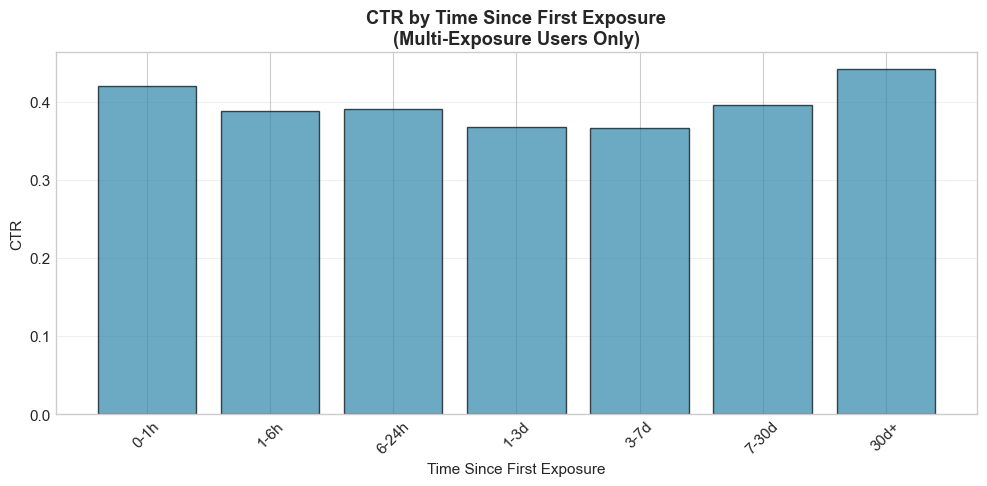


Figure saved to ../results/figures/rq1_time_based_ctr.png


In [32]:
print("=" * 70)
print("TIME-BASED FATIGUE ANALYSIS")
print("=" * 70)

# Check if we have time features
time_cols = ['hours_since_first_exposure', 'hours_since_last_exposure', 'timestamp']
available_time_cols = [c for c in time_cols if c in df.columns]
print(f"\nAvailable time columns: {available_time_cols}")

if 'hours_since_first_exposure' in df.columns:
    # Bin by hours since first exposure
    df['time_bucket'] = pd.cut(
        df['hours_since_first_exposure'],
        bins=[0, 1, 6, 24, 72, 168, 720, float('inf')],
        labels=['0-1h', '1-6h', '6-24h', '1-3d', '3-7d', '7-30d', '30d+']
    )
    
    # CTR by time bucket (for multi-exposure users only)
    multi_exp_df = df[df['exposure_count'] > 1]
    time_ctr = multi_exp_df.groupby('time_bucket')['click'].agg(['mean', 'count']).reset_index()
    time_ctr.columns = ['time_since_first', 'ctr', 'n']
    time_ctr = time_ctr[time_ctr['n'] >= 50]
    
    print(f"\nCTR by Time Since First Exposure (multi-exposure users only):")
    print(f"\n{'Time Window':<15} {'CTR':<10} {'N Impressions':<15}")
    print("-" * 45)
    for _, row in time_ctr.iterrows():
        print(f"{str(row['time_since_first']):<15} {row['ctr']:.4f}     {int(row['n']):,}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(range(len(time_ctr)), time_ctr['ctr'], alpha=0.7, color='#2E86AB', edgecolor='black')
    ax.set_xticks(range(len(time_ctr)))
    ax.set_xticklabels(time_ctr['time_since_first'], rotation=45)
    ax.set_xlabel('Time Since First Exposure')
    ax.set_ylabel('CTR')
    ax.set_title('CTR by Time Since First Exposure\n(Multi-Exposure Users Only)', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('../results/figures/rq1_time_based_ctr.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nFigure saved to ../results/figures/rq1_time_based_ctr.png")


## Step 8: Summary and Recommendations


In [33]:
print("="*70)
print("RESEARCH QUESTION 1: SUMMARY")
print("="*70)

print("""
QUESTION: How many impressions does it take before an ad's CTR meaningfully declines?

METHODOLOGY:
- Used time-bounded, within-user cohort analysis to control for survivorship bias
- Compared the same user-campaign pairs across exposure levels
- CTR at exposure N = click rate of the Nth impression (not cumulative)

KEY FINDINGS:
""")

# Summarize findings
if len(cohort_ctr) >= 3:
    print(f"1. BASELINE CTR (Exposure 1): {baseline_ctr:.4f} ({baseline_ctr*100:.2f}%)")
    
    # Find key milestones
    exp_2_row = cohort_ctr[cohort_ctr['exposure'] == 2]
    exp_5_row = cohort_ctr[cohort_ctr['exposure'] == 5]
    
    if len(exp_2_row) > 0:
        exp_2_ctr = exp_2_row['ctr'].values[0]
        exp_2_decline = (baseline_ctr - exp_2_ctr) / baseline_ctr * 100
        print(f"\n2. CTR AT EXPOSURE 2: {exp_2_ctr:.4f} ({exp_2_decline:+.1f}% from baseline)")
    
    if len(exp_5_row) > 0:
        exp_5_ctr = exp_5_row['ctr'].values[0]
        exp_5_decline = (baseline_ctr - exp_5_ctr) / baseline_ctr * 100
        print(f"\n3. CTR AT EXPOSURE 5: {exp_5_ctr:.4f} ({exp_5_decline:+.1f}% from baseline)")
    
    # Fatigue thresholds
    print(f"\n4. FATIGUE THRESHOLDS:")
    for threshold, result in found_thresholds.items():
        print(f"   - {threshold*100:.0f}% decline reached at exposure {result['threshold_exposure']}")

print("""
RECOMMENDATIONS:

1. FREQUENCY CAPPING:
   - Consider capping frequency based on identified fatigue thresholds
   - Monitor CTR closely after the 2nd-3rd exposure

2. CREATIVE ROTATION:
   - Rotate creatives before significant fatigue sets in
   - Vary messaging to reduce monotony

3. PERSONALIZATION:
   - Some users may have higher fatigue tolerance
   - Consider dynamic frequency caps based on user engagement patterns

4. MEASUREMENT:
   - Always use within-user analysis to measure fatigue
   - Avoid naive CTR-by-exposure analysis (survivorship bias)
""")


RESEARCH QUESTION 1: SUMMARY

QUESTION: How many impressions does it take before an ad's CTR meaningfully declines?

METHODOLOGY:
- Used time-bounded, within-user cohort analysis to control for survivorship bias
- Compared the same user-campaign pairs across exposure levels
- CTR at exposure N = click rate of the Nth impression (not cumulative)

KEY FINDINGS:

1. BASELINE CTR (Exposure 1): 0.5285 (52.85%)

2. CTR AT EXPOSURE 2: 0.4475 (+15.3% from baseline)

3. CTR AT EXPOSURE 5: 0.3850 (+27.1% from baseline)

4. FATIGUE THRESHOLDS:
   - 10% decline reached at exposure 2
   - 20% decline reached at exposure 3

RECOMMENDATIONS:

1. FREQUENCY CAPPING:
   - Consider capping frequency based on identified fatigue thresholds
   - Monitor CTR closely after the 2nd-3rd exposure

2. CREATIVE ROTATION:
   - Rotate creatives before significant fatigue sets in
   - Vary messaging to reduce monotony

3. PERSONALIZATION:
   - Some users may have higher fatigue tolerance
   - Consider dynamic frequen

In [13]:
# Save results
import os
os.makedirs('../results/tables', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)

# Save cohort CTR analysis
cohort_ctr.to_csv('../results/tables/rq1_cohort_ctr_by_exposure.csv', index=False)
print("Saved: ../results/tables/rq1_cohort_ctr_by_exposure.csv")

# Save statistical test results
if len(test_results) > 0:
    test_results_df = pd.DataFrame(test_results)
    test_results_df.to_csv('../results/tables/rq1_ctr_decline_tests.csv', index=False)
    print("Saved: ../results/tables/rq1_ctr_decline_tests.csv")

# Save paired analysis
if len(paired_df) > 0:
    paired_df.to_csv('../results/tables/rq1_paired_analysis.csv', index=False)
    print("Saved: ../results/tables/rq1_paired_analysis.csv")

# Save fatigue thresholds
if found_thresholds:
    threshold_data = []
    for thresh, result in found_thresholds.items():
        threshold_data.append({
            'decline_threshold': thresh,
            'threshold_exposure': result['threshold_exposure'],
            'baseline_ctr': result['baseline_ctr'],
            'threshold_ctr': result['threshold_ctr'],
            'actual_decline_pct': result['actual_decline_pct']
        })
    threshold_df = pd.DataFrame(threshold_data)
    threshold_df.to_csv('../results/tables/rq1_fatigue_thresholds.csv', index=False)
    print("Saved: ../results/tables/rq1_fatigue_thresholds.csv")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)


Saved: ../results/tables/rq1_cohort_ctr_by_exposure.csv
Saved: ../results/tables/rq1_ctr_decline_tests.csv
Saved: ../results/tables/rq1_paired_analysis.csv
Saved: ../results/tables/rq1_fatigue_thresholds.csv

ANALYSIS COMPLETE!


---

# Summary of Findings: CTR Fatigue Analysis

## Dataset Overview
| Metric | Value |
|--------|-------|
| Total impression records | 500,000 |
| Unique users | 297,407 |
| Unique campaigns | 675 |
| Unique user-campaign pairs | 323,705 |

## Exposure Distribution
- **64.74%** of all impressions are first-time exposures (exposure_count = 1)
- Median max exposure per user-campaign pair: **1** (most users see an ad only once)
- Mean exposure count: **2.76** | Max: **196**

---

## Key Insight 1: Survivorship Bias in Naive Analysis

**Problem Identified:** Naive CTR-by-exposure analysis shows CTR *increasing* with exposure:
- CTR at Exposure 1: **30.43%**
- CTR at Exposure 5: **38.50%** (+26.5%)
- CTR at Exposure 10: **43.33%** (+42.4%)

**Root Cause:** Users who eventually see 50+ impressions have **2.05x higher CTR** at their FIRST exposure (55.98% vs 27.32%) compared to single-impression users. This confirms **selection bias** - high-exposure users are inherently more engaged, not that exposure causes higher CTR.

---

## Key Insight 2: Correct Analysis Shows CTR Decline

Using **cohort analysis** (tracking 13,664 user-campaign pairs with 5+ exposures):

| Exposure | CTR | Change from Baseline | 95% CI |
|----------|-----|---------------------|--------|
| 1 (Baseline) | **52.85%** | — | [52.01%, 53.68%] |
| 2 | **44.75%** | **-15.3%** | [43.91%, 45.58%] |
| 3 | **41.58%** | **-21.3%** | [40.75%, 42.40%] |
| 4 | **39.18%** | **-25.9%** | [38.36%, 40.00%] |
| 5 | **38.50%** | **-27.1%** | [37.69%, 39.32%] |

**Finding:** CTR declines rapidly in early exposures, reaching maximum decline (~27%) around exposure 5, then partially recovers at higher exposures (likely due to smaller sample sizes and truly engaged users remaining).

---

## Key Insight 3: Statistical Significance

All CTR declines are **statistically significant** (p < 0.001):

| Comparison | CTR 1 | CTR 2 | Decline | p-value |
|------------|-------|-------|---------|---------|
| Exp 1 vs 2 | 44.47% | 34.05% | +23.4% | < 0.0001 |
| Exp 1 vs 3 | 49.59% | 35.39% | +28.6% | < 0.0001 |
| Exp 1 vs 5 | 52.85% | 38.50% | +27.1% | < 0.0001 |
| Exp 1 vs 10 | 55.53% | 43.33% | +22.0% | < 0.0001 |
| Exp 2 vs 5 | 44.75% | 38.50% | +14.0% | < 0.0001 |
| Exp 5 vs 10 | 47.05% | 43.33% | +7.9% | 0.0015 |

---

## Key Insight 4: Fatigue Thresholds

| Decline Level | Exposure at Threshold | CTR at Threshold |
|---------------|----------------------|------------------|
| **10% decline** | Exposure **2** | 44.75% |
| **20% decline** | Exposure **3** | 41.58% |
| 30% decline | Not reached in data | — |
| 50% decline | Not reached in data | — |

**Interpretation:** Fatigue sets in **very early** - by the 2nd impression, CTR has already dropped by 15%. By the 3rd impression, it has dropped by over 20%.

---

## Key Insight 5: Within-User Paired Analysis

Most robust test comparing the **same users** at different exposures:

| Comparison | N Pairs | CTR Exp 1 | CTR Exp N | Mean Change | Significance |
|------------|---------|-----------|-----------|-------------|--------------|
| Exp 1 vs 2 | 58,648 | 44.47% | 34.05% | **-10.42 pp** | p < 0.001 *** |
| Exp 1 vs 3 | 31,720 | 49.59% | 35.39% | **-14.20 pp** | p < 0.001 *** |
| Exp 1 vs 5 | 13,664 | 52.85% | 38.50% | **-14.34 pp** | p < 0.001 *** |
| Exp 1 vs 10 | 3,607 | 55.53% | 43.33% | **-12.20 pp** | p < 0.001 *** |

**Finding:** When comparing the same user-campaign pairs, CTR drops by **10-14 percentage points** from first to subsequent exposures.

---

## Key Insight 6: Time-Based Fatigue

CTR by time since first exposure (multi-exposure users):

| Time Window | CTR | N Impressions |
|-------------|-----|---------------|
| 0-1 hour | 41.95% | 12,717 |
| 1-6 hours | 38.83% | 5,292 |
| 6-24 hours | 39.06% | 10,096 |
| 1-3 days | **36.78%** | 25,828 |
| 3-7 days | **36.59%** | 37,104 |
| 7-30 days | 39.64% | 85,036 |

**Finding:** CTR is lowest in the **1-7 day window** after first exposure, suggesting fatigue peaks during this period before users either disengage or become more receptive again.

---

## Conclusions

### Answer to Research Question
> **How many impressions does it take before an ad's CTR meaningfully declines?**

**Answer: CTR meaningfully declines after just 2 impressions.**

- **10% decline** occurs by the **2nd exposure**
- **20% decline** occurs by the **3rd exposure**
- Maximum decline (~27%) occurs around the **5th exposure**
- Fatigue is strongest in the **1-7 day window** after first exposure

### Business Recommendations

1. **Frequency Cap at 3-5 impressions** per user-campaign to avoid significant fatigue
2. **Rotate creatives** after 2-3 exposures to maintain engagement
3. **Space out impressions** - avoid clustering multiple exposures in a short time window
4. **Monitor within-user CTR** (not aggregate CTR) to accurately measure fatigue
5. **Consider user segments** - high-engagement users may tolerate more exposures

### Methodological Takeaways

- **Never use naive CTR-by-exposure analysis** - it shows the opposite of reality due to survivorship bias
- **Always use cohort or within-user analysis** to control for selection effects
- **Time-bound metrics** (CTR of Nth impression) are more accurate than cumulative metrics
